In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_290_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_291_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_292_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_293_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_294_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_295_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_296_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_297_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_298_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_299_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_2_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_300_100.jpg  
  inflating: fruits-360_dat

# Problem 1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'



BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [3]:
data_gen = ImageDataGenerator(
    rescale=1./255,  # normalize
    validation_split=0.15,  # validation split
    rotation_range=25,  # data augmentation
)

# Load datasets
train_gen = data_gen.flow_from_directory(
    train_path,  # path to training data
    target_size=IMG_SIZE,  # resize images
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training',  # use training subset
)

valid_gen = data_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation',  # use validation subset
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)


Found 57612 images belonging to 131 classes.
Found 10080 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [26]:
def create_model1(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    model = models.Sequential()

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model2(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    model = models.Sequential()

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv layer
    model.add(layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model_bonus(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    inputs = layers.Input(shape=(75, 75, 3))

    # First Conv layer
    x1 = layers.Conv2D(128, (3,3), strides=(1,1), padding = 'same', activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(inputs)
    x2 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x2_reduced = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x2)  # Reduce size for skip connection

    # Second Conv layer
    x3 = layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', padding = 'same', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(x2)
    x4 = layers.MaxPooling2D(pool_size=(2, 2))(x3)

    # Concatenate for skip connection
    skip_connection = layers.concatenate([x4, x2_reduced])

    # Third Conv layer
    x5 = layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(skip_connection)
    x6 = layers.BatchNormalization(momentum=0.99, epsilon=0.001)(x5)
    x7 = layers.Dropout(dropout_rate)(x6)
    x8 = layers.MaxPooling2D(pool_size=(2, 2))(x7)

    flat = layers.Flatten()(x8)

    # Dense Layers
    dense1 = layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(flat)
    outputs = layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(dense1)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model




Epoch 1/30
57/57 [==============================] - 141s 2s/step - loss: 0.9707 - accuracy: 0.7915 - val_loss: 3.3548 - val_accuracy: 0.2289
Epoch 2/30
57/57 [==============================] - 116s 2s/step - loss: 0.0190 - accuracy: 0.9951 - val_loss: 2.3406 - val_accuracy: 0.6969
Epoch 3/30
57/57 [==============================] - 117s 2s/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 1.5490 - val_accuracy: 0.8736
Epoch 4/30
57/57 [==============================] - 117s 2s/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 1.0448 - val_accuracy: 0.9001
Epoch 5/30
57/57 [==============================] - 117s 2s/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.9159 - val_accuracy: 0.8081
Epoch 6/30
57/57 [==============================] - 118s 2s/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.5087 - val_accuracy: 0.8879
Epoch 7/30
57/57 [==============================] - 116s 2s/step - loss: 0.0466 - accuracy: 0.9888 - val_loss: 1.2683 - val_accuracy: 0.6289
Epoch 8/30
57

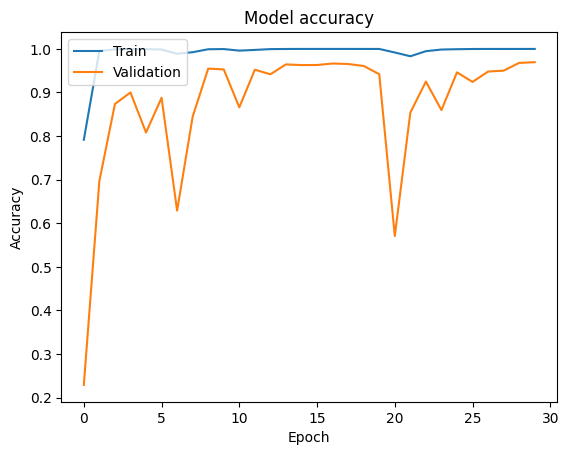

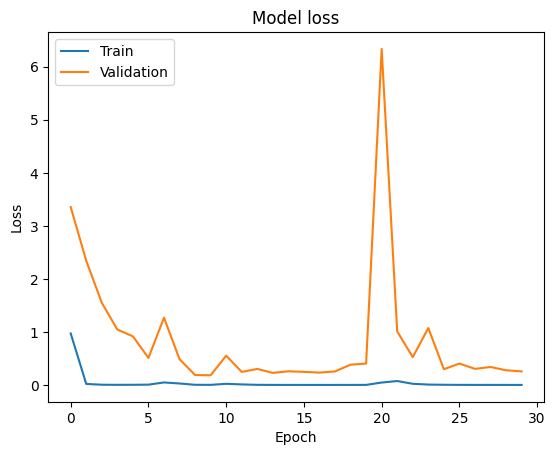

In [5]:
model1_1 = create_model1(0.1)

model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Calculate step size
    validation_steps=valid_gen.samples // BATCH_SIZE
)

test_loss, test_accuracy = model1_1.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/30
57/57 [==============================] - 120s 2s/step - loss: 1.4428 - accuracy: 0.7061 - val_loss: 3.4145 - val_accuracy: 0.2282
Epoch 2/30
57/57 [==============================] - 116s 2s/step - loss: 0.0216 - accuracy: 0.9946 - val_loss: 2.6095 - val_accuracy: 0.4258
Epoch 3/30
57/57 [==============================] - 117s 2s/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 2.1887 - val_accuracy: 0.5057
Epoch 4/30
57/57 [==============================] - 117s 2s/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 1.7901 - val_accuracy: 0.5422
Epoch 5/30
57/57 [==============================] - 117s 2s/step - loss: 9.2810e-04 - accuracy: 1.0000 - val_loss: 1.4072 - val_accuracy: 0.6098
Epoch 6/30
57/57 [==============================] - 116s 2s/step - loss: 7.5444e-04 - accuracy: 1.0000 - val_loss: 1.2651 - val_accuracy: 0.6220
Epoch 7/30
57/57 [==============================] - 117s 2s/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 1.8322 - val_accuracy: 0.4845
Epoch

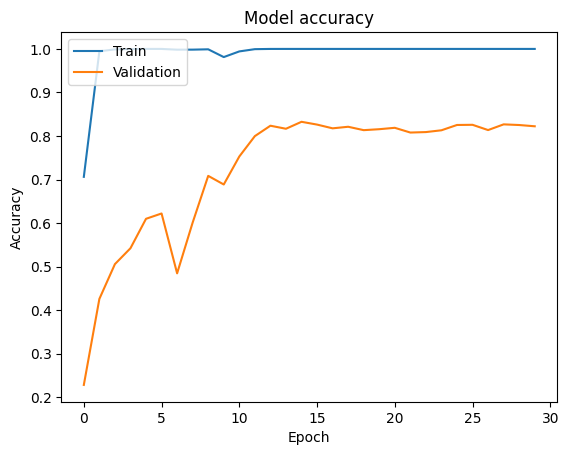

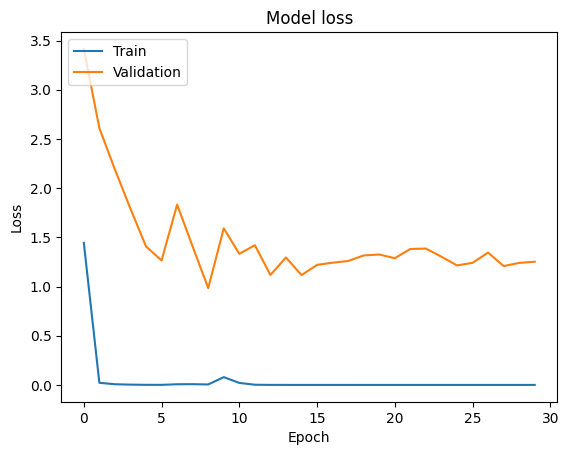

In [6]:
model1_3 = create_model1(0.3)

model1_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_3.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Calculate step size
    validation_steps=valid_gen.samples // BATCH_SIZE
)

test_loss, test_accuracy = model1_3.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/30
57/57 [==============================] - 120s 2s/step - loss: 1.7917 - accuracy: 0.6573 - val_loss: 3.6664 - val_accuracy: 0.0820
Epoch 2/30
57/57 [==============================] - 117s 2s/step - loss: 0.0280 - accuracy: 0.9936 - val_loss: 3.0591 - val_accuracy: 0.2764
Epoch 3/30
57/57 [==============================] - 117s 2s/step - loss: 0.0165 - accuracy: 0.9968 - val_loss: 2.6828 - val_accuracy: 0.3483
Epoch 4/30
57/57 [==============================] - 116s 2s/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 2.3402 - val_accuracy: 0.3831
Epoch 5/30
57/57 [==============================] - 117s 2s/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 1.8112 - val_accuracy: 0.5031
Epoch 6/30
57/57 [==============================] - 116s 2s/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 1.5032 - val_accuracy: 0.5810
Epoch 7/30
57/57 [==============================] - 116s 2s/step - loss: 7.4881e-04 - accuracy: 1.0000 - val_loss: 1.3528 - val_accuracy: 0.5864
Epoch 8/3

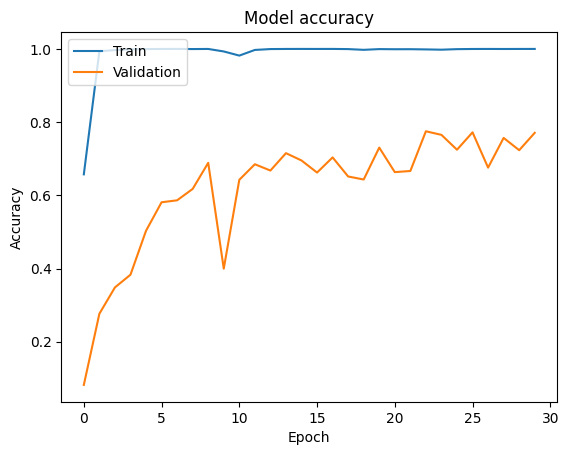

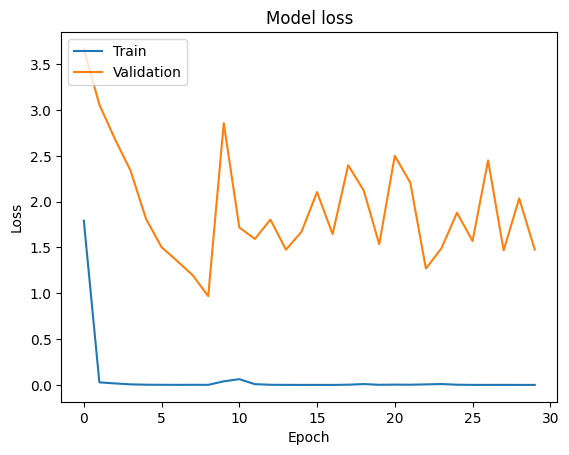

In [7]:
model1_5 = create_model1(0.5)

model1_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_5.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Calculate step size
    validation_steps=valid_gen.samples // BATCH_SIZE
)

test_loss, test_accuracy = model1_5.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/30
57/57 [==============================] - 123s 2s/step - loss: 0.8740 - accuracy: 0.7973 - val_loss: 2.8634 - val_accuracy: 0.4443
Epoch 2/30
57/57 [==============================] - 118s 2s/step - loss: 0.0194 - accuracy: 0.9954 - val_loss: 2.0095 - val_accuracy: 0.6529
Epoch 3/30
57/57 [==============================] - 117s 2s/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 1.2239 - val_accuracy: 0.8374
Epoch 4/30
57/57 [==============================] - 118s 2s/step - loss: 0.0063 - accuracy: 0.9986 - val_loss: 0.9168 - val_accuracy: 0.7890
Epoch 5/30
57/57 [==============================] - 118s 2s/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 1.2259 - val_accuracy: 0.6280
Epoch 6/30
57/57 [==============================] - 117s 2s/step - loss: 0.0541 - accuracy: 0.9873 - val_loss: 2.3317 - val_accuracy: 0.5120
Epoch 7/30
57/57 [==============================] - 117s 2s/step - loss: 0.0309 - accuracy: 0.9921 - val_loss: 1.3900 - val_accuracy: 0.7559
Epoch 8/30
57

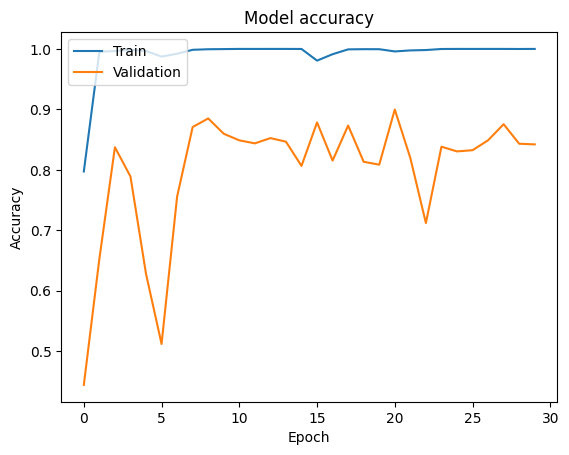

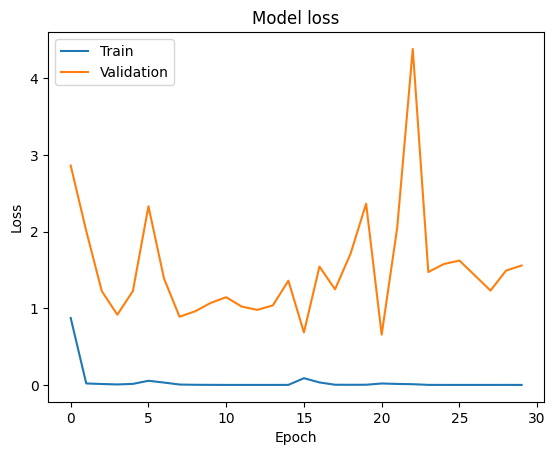

In [8]:
model2 = create_model2(0.3)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Calculate step size
    validation_steps=valid_gen.samples // BATCH_SIZE
)

test_loss, test_accuracy = model2.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/30
57/57 [==============================] - 167s 2s/step - loss: 1.0717 - accuracy: 0.7643 - val_loss: 2.7919 - val_accuracy: 0.3708
Epoch 2/30
57/57 [==============================] - 118s 2s/step - loss: 0.0162 - accuracy: 0.9967 - val_loss: 1.7479 - val_accuracy: 0.6719
Epoch 3/30
57/57 [==============================] - 117s 2s/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 1.1387 - val_accuracy: 0.8381
Epoch 4/30
57/57 [==============================] - 118s 2s/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.8136 - val_accuracy: 0.8297
Epoch 5/30
57/57 [==============================] - 117s 2s/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.7430 - val_accuracy: 0.8295
Epoch 6/30
57/57 [==============================] - 117s 2s/step - loss: 9.6811e-04 - accuracy: 0.9999 - val_loss: 0.7436 - val_accuracy: 0.8056
Epoch 7/30
57/57 [==============================] - 117s 2s/step - loss: 5.9280e-04 - accuracy: 1.0000 - val_loss: 0.7639 - val_accuracy: 0.8011
Epoch

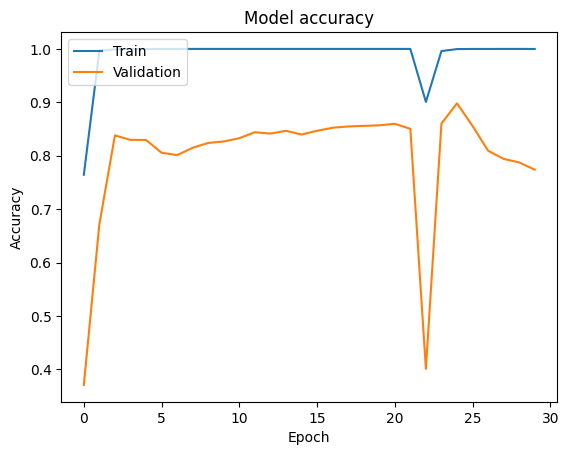

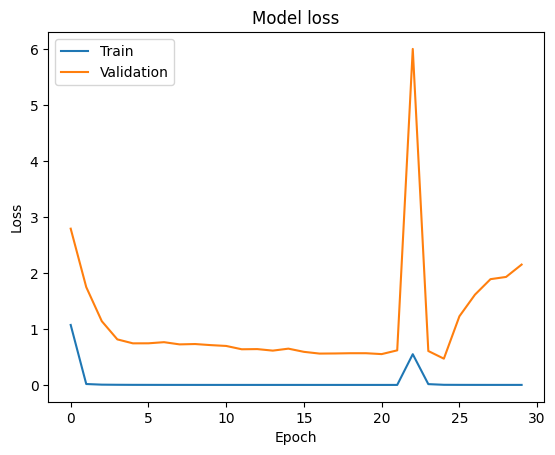

In [27]:
model_bonus = create_model_bonus(0.3)

model_bonus.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_bonus.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,  # Calculate step size
    validation_steps=valid_gen.samples // BATCH_SIZE
)

test_loss, test_accuracy = model_bonus.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Problem 2

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=2000)
word_index = imdb.get_word_index()

# Pad the sequences
x_train = pad_sequences(x_train, maxlen=300)
x_test = pad_sequences(x_test, maxlen=300)


1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split 1000 samples for validation
x_val = x_train[:1000]
y_val = y_train[:1000]
x_train_partial = x_train[1000:]
y_train_partial = y_train[1000:]

history = model.fit(x_train_partial, y_train_partial, epochs=30, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/30
750/750 [==============================] - 19s 24ms/step - loss: 0.4733 - accuracy: 0.7643 - val_loss: 0.3594 - val_accuracy: 0.8380
Epoch 2/30
750/750 [==============================] - 27s 36ms/step - loss: 0.3002 - accuracy: 0.8728 - val_loss: 0.3195 - val_accuracy: 0.8570
Epoch 3/30
750/750 [==============================] - 18s 24ms/step - loss: 0.2496 - accuracy: 0.8965 - val_loss: 0.3036 - val_accuracy: 0.8760
Epoch 4/30
750/750 [==============================] - 17s 22ms/step - loss: 0.2145 - accuracy: 0.9149 - val_loss: 0.3262 - val_accuracy: 0.8670
Epoch 5/30
750/750 [==============================] - 17s 22ms/step - loss: 0.1873 - accuracy: 0.9274 - val_loss: 0.3263 - val_accuracy: 0.8640
Epoch 6/30
750/750 [==============================] - 19s 25ms/step - loss: 0.1637 - accuracy: 0.9388 - val_loss: 0.3399 - val_accuracy: 0.8630
Epoch 7/30
750/750 [==============================] - 16s 22ms/step - loss: 0.1395 - accuracy: 0.9519 - val_loss: 0.3740 - val_accuracy:

In [ ]:
results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')


782/782 [==============================] - 7s 8ms/step - loss: 1.1339 - accuracy: 0.8567
Test loss: 1.1338602304458618, Test accuracy: 0.856719970703125


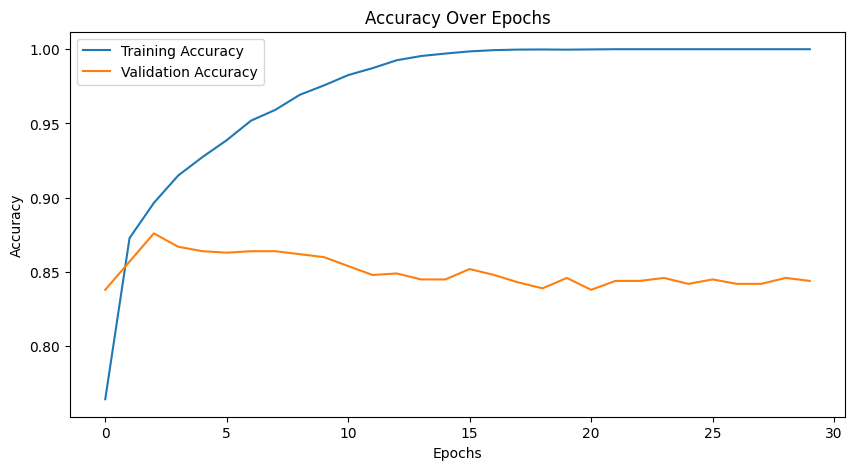

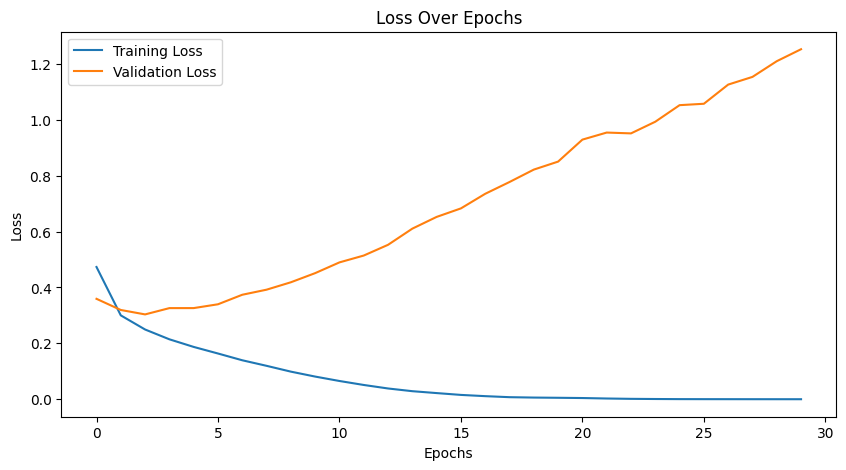

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
# Add Normalization
model.add(BatchNormalization())
# Add dropout
model.add(Dropout(0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # stops after 3 epochs of no improvement

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Split 500 samples for validation
x_val = x_train[:500]
y_val = y_train[:500]
x_train_partial = x_train[500:]
y_train_partial = y_train[500:]

history = model.fit(x_train_partial, y_train_partial, epochs=30, batch_size=4, validation_data=(x_val, y_val), callbacks=[early_stopping])

results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')

import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()